In [1]:
# Standars libraries
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import seaborn as sns
import pickle
import itertools as it
from collections import Counter
import pyspark
from pyspark import *
from pyspark.sql import *
from pyspark.sql.functions import *

# Utilities functions
import sys
sys.path.append('/home/fanfou/Panorama/notebooks/utils')
from visualization import *
from tools import *

# Display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_colwidth', 199)

# Import  and view all tweets

In [2]:
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext
jsondf = spark.read.json("/mnt/datastore/data/coronavirus/*.json");
jsondf.count()

9365809

In [3]:
jsondf.printSchema()

root
 |-- author_handle: string (nullable = true)
 |-- geo_location: string (nullable = true)
 |-- lang: string (nullable = true)
 |-- likes: long (nullable = true)
 |-- main: string (nullable = true)
 |-- permalink: string (nullable = true)
 |-- published: string (nullable = true)
 |-- replied: boolean (nullable = true)
 |-- shared_type: string (nullable = true)
 |-- shares: long (nullable = true)
 |-- source_followers: long (nullable = true)
 |-- source_following: long (nullable = true)



In [4]:
from pyspark.sql import functions as F
groupHour = jsondf.select(F.date_format('published','yyyy-MM-dd hh').alias('date')).groupby("date").count().toPandas()
groupHour['date'] = pd.to_datetime(groupHour['date'])
groupHour = groupHour.sort_values(by=['date'], ascending=True)


/home/fanfou/.local/lib/python2.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


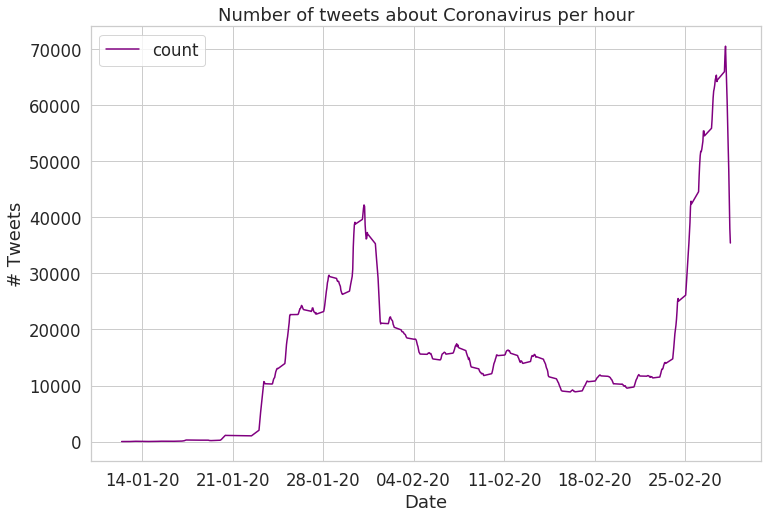

In [5]:
plotTweetPerDay(groupHour[groupHour['date'] > "2020-01-12"], "Number of tweets about Coronavirus per hour", rolling_window=10, col_count="count")

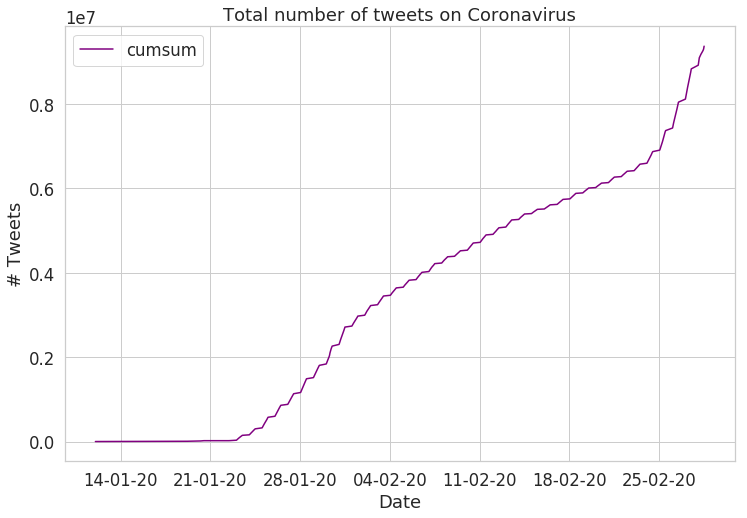

In [6]:
# Prettier plotting with seaborn
sns.set(font_scale=1.5, style="whitegrid")

fig, ax = plt.subplots(figsize=(12, 8))

groupHour['cumsum'] = groupHour['count'].cumsum()
df = groupHour[groupHour['date'] > "2020-01-12"]

# Compute rolling mean of the count if needed
y =  df['cumsum'].rolling(window=1).mean()

ax.plot(df['date'],
       y,
        '-o',
        color='purple', marker="")
ax.set(xlabel="Date", ylabel="# Tweets",
       title="Total number of tweets on Coronavirus")

# Format the x axis
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
ax.xaxis.set_major_formatter(DateFormatter("%d-%m-%y"))

# Ensure ticks fall once every other week (interval=2) 
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
plt.legend()
plt.show()

## Filter by known medias

In [7]:
RELOAD = False
TWEETS_MEDIAS_PATH = "/mnt/datastore/data/tweets_medias.csv"

if RELOAD:
    medias_accounts = pd.read_csv("/mnt/datastore/data/top_twitter_medias.csv", header=None)
    tweets_medias = jsondf.filter(col("author_handle").isin(medias_accounts[0].values.tolist())).toPandas()
    tweets_medias['published'] = pd.to_datetime(tweets_medias['published'], infer_datetime_format=True)
    tweets_medias.to_csv(TWEETS_MEDIAS_PATH, encoding='utf-8', index=False)
else :
    tweets_medias = pd.read_csv(TWEETS_MEDIAS_PATH)
    tweets_medias['published'] = pd.to_datetime(tweets_medias['published'], infer_datetime_format=True) 

tweets_medias.count()

author_handle       77883
geo_location        45181
lang                77883
likes               77881
main                77883
permalink           77883
published           77883
replied             77883
shared_type         77883
shares              77881
source_followers    77883
source_following    77883
dtype: int64

### Dataset Summary

In [8]:
tweets_medias.head()

,author_handle,geo_location,lang,likes,main,permalink,published,replied,shared_type,shares,source_followers,source_following
0,MyNews13,"Orlando, FL",en,0.0,What’s the biggest way to keep a virus away? Health officials Agree it’s washing your hands. There’s a right way to do it! @ybruzual demonstrates. #Covid_19 coverage: https://www.mynews13.com/fl/...,https://twitter.com/MyNews13/status/1233127388764086273,2020-02-27 20:30:54,False,REPLY,0.0,258797,2063
1,radionz,NaN,en,3.0,"""Coronavirus is a global health crisis, with confirmed cases of the virus in over 25 countries where people are not banned from travelling to New Zealand. ""Covid-19 cannot simply be attributed to...",https://twitter.com/radionz/status/1233103771040792578,2020-02-27 18:57:03,False,REPLY,1.0,44730,331
2,vdare,NaN,en,2.0,"It's becoming increasingly clear calling Trump a ""racist"" is a higher priority to Democrats than actual protecting the American people. #Coronavirus #CoronaOutbreak It's time -- #ImmigrationMorat...",https://twitter.com/vdare/status/1233063539839033345,2020-02-27 16:17:11,False,REPLY,0.0,43383,4177
3,varunkrish,NaN,en,0.0,Thank the heavens for MWC being cancelled. Such a huge spike in new infections around the world especially in Europe Coronavirus in Spain: Spain reports first locally transmitted case. “The virus...,https://twitter.com/varunkrish/status/1233123449385570304,2020-02-27 20:15:15,False,REPLY,0.0,23596,3485
4,tokyoreporter,NaN,en,2.0,Dentsu employee tests positive for coronavirus 【速報】大手広告代理店の「電通」は、東京・港区の電通本社ビルに勤務する５０代の男性従業員１人が新型コロナウイルスの感染検査で「陽性」であることが確認されたと発表しました。あすから本社ビルに勤務する全従業員について、在宅勤務に切り替えるということです。 #新型コロナウイルス #新型肺炎 pic.t...,https://twitter.com/tokyoreporter/status/1232253431089266688,2020-02-25 10:38:06,False,REPLY,3.0,49825,982


### Volume of tweets

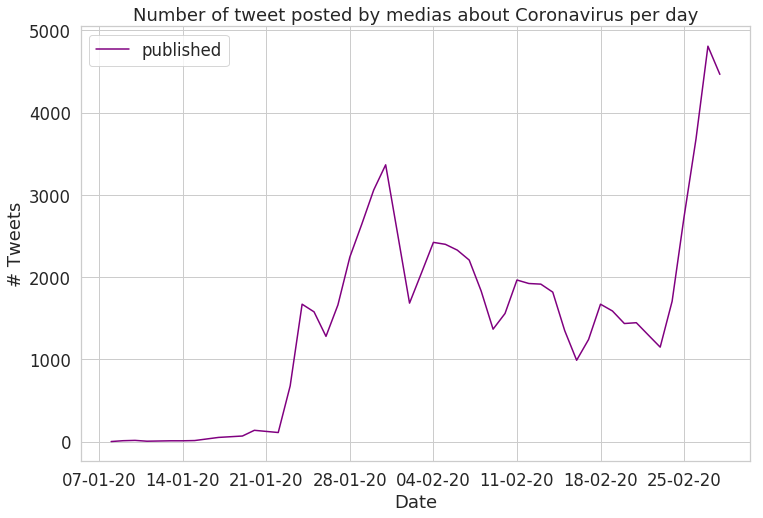

In [9]:
tweets_medias_count = countByDay(tweets_medias, "published")
title = "Number of tweet posted by medias about Coronavirus per day"
plotTweetPerDay(tweets_medias_count, title, rolling_window=2)

## Putting everything together

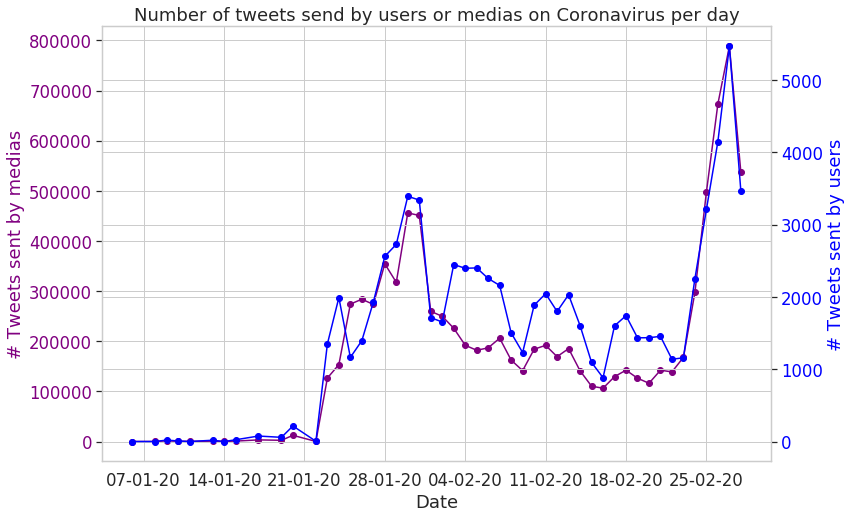

In [22]:
tweets_per_day = groupHour.groupby([groupHour.date.dt.year, groupHour.date.dt.month, groupHour.date.dt.day])['count'].sum()
tweets_per_day.index.names = ['Year', 'Month','Day']
tweets_per_day = tweets_per_day.reset_index()
tweets_per_day['date'] = pd.to_datetime(tweets_per_day[['Year', 'Month', 'Day']])
tweets_per_day = tweets_per_day[['date', 'count']]

merge = tweets_medias_count.merge(tweets_per_day, left_on='date', right_on='date', how='inner').fillna(0)
plotTweetPerDay2Axis(merge, "count", "published", "date", y_1_label="# Tweets sent by medias", y_2_label="# Tweets sent by users")


## Tweets reactions

Get All tweets with actual number of retweets, likes and url of the article if there is one

In [59]:
# Save the list of tweets ids to use them with the twitter api
with open('/mnt/datastore/data/media_tweets_ids.txt', 'wb') as f:
    pickle.dump(tweets_medias.permalink.str.split("/").str[-1].values, f)

In [60]:
medias_with_reactions = pd.read_csv("/mnt/datastore/data/tweets_medias_full.csv")
medias_with_reactions['created_at'] = pd.to_datetime(medias_with_reactions['created_at'], infer_datetime_format=True)
medias_with_reactions = medias_with_reactions.sort_values(by=['retweets'], ascending=False)
medias_with_reactions.head(5)

,tweet_id,user_id,user_name,followers,friends,user_location,likes,retweets,text,created_at,url
810,1232669578339196928,18643437,PrisonPlanet,1106984,703,London,30367,11253,"Russia, which closed its border with China in the early days of the outbreak, reported just two coronavirus cases (both Chinese citizens who have now recovered).\n\nIn comparison, Italy, which im...",2020-02-26 14:11:44+00:00,NaN
526,1221800661039419398,14499829,WHO,5581967,1716,"Geneva, Switzerland",5243,4938,"Q: Are antibiotics effective in preventing and treating the new #coronavirus (2019-nCoV)?\nA: No, antibiotics do not work against viruses, only bacteria.\nThe 2019-nC0V is a virus and, therefore,...",2020-01-27 14:22:32+00:00,NaN
39,1232446134863269889,594886554,TheLastRefuge2,158248,2240,United States,4541,4859,"1) Earlier today Dr. Nancy Messonnier, an official in the Centers for Disease Control (CDC), held a conference call with media and pushed a panic narrative around the Coronvirus that ran counter ...",2020-02-25 23:23:50+00:00,NaN
107,1229125978816942080,18643437,PrisonPlanet,1106981,703,London,6665,2995,"CNN/NY Times journo says coronavirus might have emerged from lab in Wuhan after someone was bitten by a bat during a test.\n\nFor the past month, the media has been defaming anyone who suggested ...",2020-02-16 19:30:44+00:00,NaN
578,1233414293158334464,14499829,WHO,5581971,1716,"Geneva, Switzerland",1989,2164,"@DrTedros ""There are 10 basic things that you should know.\n\n1⃣clean your 👐 regularly with an alcohol-based hand rub, or wash them with 🧼 &amp; 💧.\n\nTouching your face after touching contaminat...",2020-02-28 15:30:57+00:00,NaN


In [61]:
medias_with_reactions.count()

tweet_id         887
user_id          887
user_name        887
followers        887
friends          887
user_location    801
likes            887
retweets         887
text             887
created_at       887
url              332
dtype: int64

> Top retweets by media

In [62]:
medias_with_reactions[['retweets', 'user_name']].groupby('user_name').sum().sort_values(by=['retweets'], ascending=False).head(10)

,retweets
user_name,
PrisonPlanet,17393
WHO,12445
TheLastRefuge2,9901
ANI,5664
rapplerdotcom,2645
NPR,2463
nytimes,1536
RT_com,1394
latimes,1371


> Top likes by media

In [63]:
medias_with_reactions[['likes', 'user_name']].groupby('user_name').sum().sort_values(by=['likes'], ascending=False).head(10)

,likes
user_name,
PrisonPlanet,44954
ANI,26480
WHO,13955
TheLastRefuge2,12581
TheOnion,8938
rapplerdotcom,8159
latimes,4184
NPR,3943
nytimes,2597


> Compute the ratio, number of retweets by number of followers and tweets

In [66]:
medias_with_reactions['ratio_retweet'] = (medias_with_reactions['retweets'])/(medias_with_reactions['followers']+1)
(medias_with_reactions[['ratio_retweet', 'user_name']].groupby('user_name').sum() / medias_with_reactions[['ratio_retweet', 'user_name']].groupby('user_name').count()).sort_values(by=['ratio_retweet'], ascending=False).head(100)


,ratio_retweet
user_name,
TheLastRefuge2,0.006952
hongfenghuang,0.004517
PrisonPlanet,0.003142
AmandaHallWINK,0.001675
radiogarowe,0.000775
SOTTnet,0.000754
siberian_times,0.000747
1450whtc,0.000738
ifrc,0.000678


## Events analysis

In [31]:
tweets_medias_full.loc[47860]['text']

'Alibaba offers $2.86 billion in loans to firms hit by coronavirus outbreak\n\nhttps://t.co/DvAbJgFH6T https://t.co/l52IeIqTsm'

In [97]:
#tweets_medias_full.sort_values(by=['created_at'], ascending=True)[tweets_medias_full["created_at"]>"2020-01-19"][tweets_medias_full["retweets"] > 100].head(100)

tweets_medias_full.sort_values(by=['created_at'], ascending=True)[tweets_medias_full["user_name"] =="WHO"].head(100)
                                                                  
                                                                  

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


,tweet_id,user_id,user_name,likes,retweets,text,created_at,url,source_followers,ratio_retweet
348,1215320529059688449,14499829,WHO,682.0,472.0,"Coronaviruses are a large family of viruses that are known to cause illness ranging from the common cold to more severe diseases, such as Middle East Respiratory Syndrome (MERS) and Severe Acute ...",2020-01-09 17:12:48+00:00,NaN,4636289,0.000102
3702,1215325442988744704,14499829,WHO,70.0,38.0,"Some coronaviruses cause less-severe disease, some more severe. Some transmit easily from person to person, while others don’t.\n\n#coronavirus https://t.co/zQpquyKEiX",2020-01-09 17:32:19+00:00,NaN,4636289,0.000008
2353,1215333430004678656,14499829,WHO,80.0,62.0,A novel #coronavirus is a new strain of the virus that has not been previously identified in humans https://t.co/G0Os4ds9cv,2020-01-09 18:04:04+00:00,NaN,4636289,0.000013
2831,1215339675415719937,14499829,WHO,73.0,50.0,"Novel coronaviruses emerge periodically, as we have seen. SARS emerged in 2002 and MERS emerged in 2012.\nSeveral known coronaviruses are currently circulating in animals that have not yet infect...",2020-01-09 18:28:53+00:00,NaN,4636289,0.000011
3106,1215347788847947776,14499829,WHO,80.0,46.0,"As surveillance improves around the world, more coronaviruses are likely to be identified.\n\n#coronavirus https://t.co/jsGXvEwOnM",2020-01-09 19:01:07+00:00,NaN,4636289,0.000010
875,1215371498317406209,14499829,WHO,180.0,180.0,Protect yourself &amp; reduce risk from #coronavirus infection:\n👏🏽Hand hygiene\n🤧Cover mouth &amp; nose when coughing &amp; sneezing\n🥩Thoroughly cook meat &amp; eggs \n🌡Avoid close contact with...,2020-01-09 20:35:20+00:00,NaN,4636289,0.000039
4232,1215695763155668993,14499829,WHO,65.0,33.0,Q&amp;A on coronaviruses https://t.co/PKzKaO2yfK\n\n#coronavirus https://t.co/apeUtPvyan,2020-01-10 18:03:51+00:00,NaN,4636289,0.000007
2279,1215720600590848000,14499829,WHO,81.0,64.0,"WHO advice for international travel and trade in relation to the outbreak of pneumonia caused by a new #coronavirus in Wuhan, #China🇨🇳 https://t.co/UU8IgFvjpn https://t.co/D13Xv9Yrt4",2020-01-10 19:42:32+00:00,NaN,4636289,0.000014
3220,1216113981141721093,14499829,WHO,84.0,45.0,"@WHOWPRO @DrTedros WHO encourages all countries to continue preparedness activities, and has issued interim guidance on how to do this.\n\n#coronavirus (2019-nCoV)\n\nhttps://t.co/mGG9fnvaSF",2020-01-11 21:45:42+00:00,NaN,4636289,0.000010
625,1216684542209200128,14499829,WHO,286.0,251.0,"WHO is working with officials in #Thailand🇹🇭 and #China🇨🇳 following reports of confirmation of the novel #coronavirus (2019-nCoV) in a traveler from #Wuhan, China, who traveled to Thailand https:...",2020-01-13 11:32:54+00:00,NaN,4636289,0.000054


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


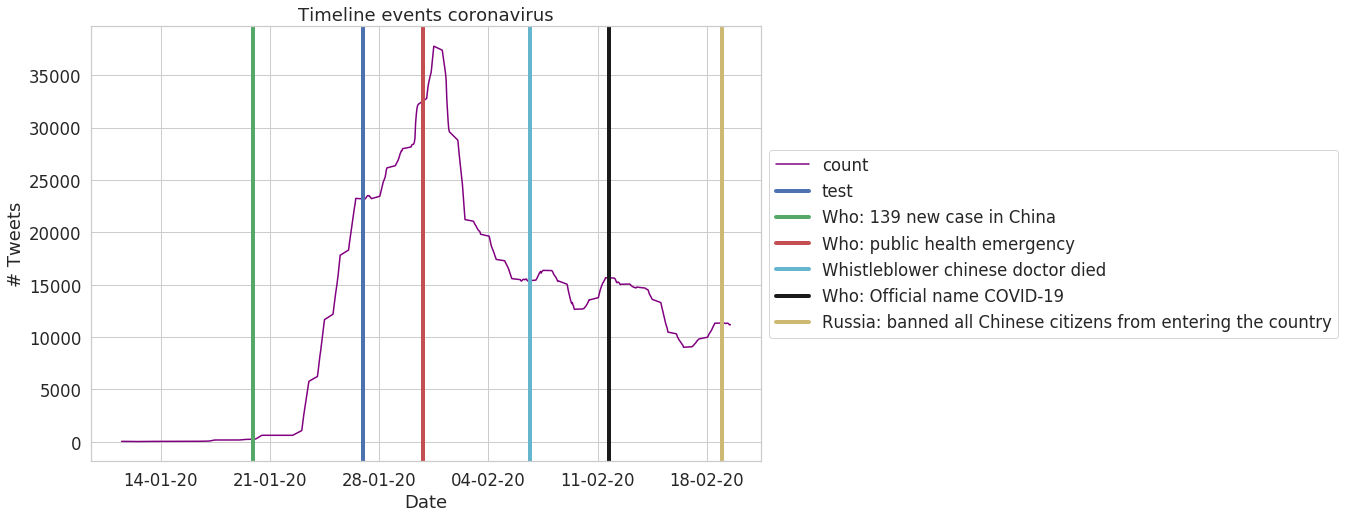

In [101]:
# Prettier plotting with seaborn
sns.set(font_scale=1.5, style="whitegrid")

fig, ax = plt.subplots(figsize=(12, 8))
df = groupHour[groupHour['date'] > "2020-01-10"][groupHour['date'] < "2020-02-20"]
# Compute rolling mean of the count if needed
y =  df['count'].rolling(window=24).mean()

ax.plot(df['date'],
       y,
        '-o',
        color='purple', marker="")
ax.set(xlabel="Date", ylabel="# Tweets",
       title="Timeline events coronavirus")

# Plot the vertical line if needed

plt.axvline(linewidth=4, color='b', x="2020-01-26 23:48:27+00:00", label="test")
#plt.axvline(linewidth=4, color='b', x="2020-01-21 18:37:41+00:00", label="first US case")
plt.axvline(linewidth=4, color='g', x="2020-01-19 22:39:07+00:00", label="Who: 139 new case in China")
plt.axvline(linewidth=4, color='r', x="2020-01-30 19:45:15+00:00", label="Who: public health emergency")
plt.axvline(linewidth=4, color='c', x="2020-02-06 15:46:26+00:00", label="Whistleblower chinese doctor died")
plt.axvline(linewidth=4, color='k', x="2020-02-11 17:20:08+00:00", label="Who: Official name COVID-19")
plt.axvline(linewidth=4, color='y', x="2020-02-18 22:45:37+00:00", label="Russia: banned all Chinese citizens from entering the country")



# Format the x axis
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
ax.xaxis.set_major_formatter(DateFormatter("%d-%m-%y"))

# Ensure ticks fall once every other week (interval=2) 
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#plt.legend()
plt.show()

## Closer look on OMS tweets

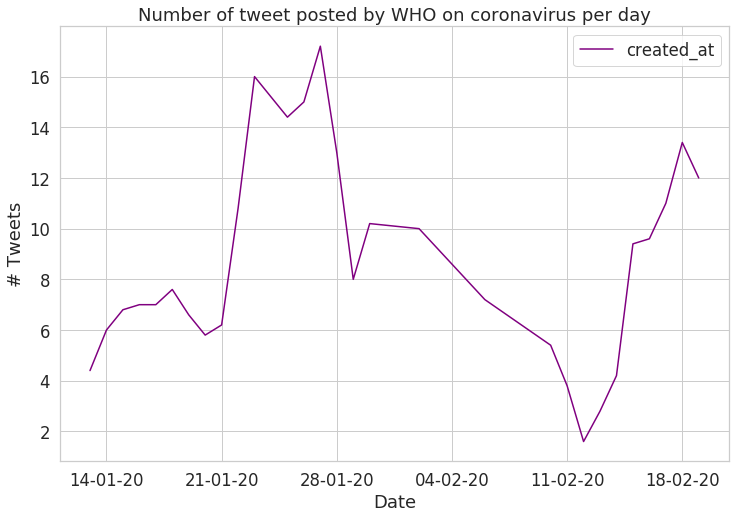

In [47]:
count_oms = countByDay(medias_with_reactions[medias_with_reactions['user_name'] == "WHO"], "created_at")
plotTweetPerDay(count_oms, "Number of tweet posted by WHO on coronavirus per day", 5, col_count="created_at")

# Tweets keywords analysis

> Preprocess tweets, lower, remove urls, etc...

In [108]:
cor_tweets_medias = pd.read_csv("/mnt/datastore/data/tweets_medias.csv")
cor_tweets_medias['published'] = pd.to_datetime(cor_tweets_medias['published'], infer_datetime_format=True) 
medias_with_reactions = pd.read_csv("/mnt/datastore/data/tweets_medias_withURL.csv")

cor_tweets_medias['tweet_id'] = cor_tweets_medias.permalink.str.split("/").str[-1]
cor_tweets_medias_full = medias_with_reactions.merge(cor_tweets_medias[['tweet_id', 'source_followers']], left_on='tweet_id', right_on='tweet_id', how='inner')
cor_tweets_medias_full['created_at'] = pd.to_datetime(cor_tweets_medias_full['created_at'], infer_datetime_format=True) 

stop_words = pd.read_csv('/mnt/datastore/data/stopwords.csv', header=None).values.flatten()

def computeTopWords(df, stopwords=None):
    # Lowercase
    df['text'] = df['text'].str.lower()

    # Remove links 
    df['text'] = df['text'].apply(remove_url)

    # Tokenize
    df['text'] = df['text'].str.split(" ")

    # Get flatten list of words
    all_words = list(it.chain(*df.text.values))

    # remove stop words 
    if stopwords is not None:
        all_words = [w for w in all_words if not w in stop_words]
    
    all_words = [w for w in all_words if not w in ['coronavirus']]
    # Create counter
    counts = Counter(all_words)

    return pd.DataFrame(counts.most_common(200),
                                 columns=['words', 'count'])


In [109]:
all_top = computeTopWords(cor_tweets_medias_full, stopwords=stop_words)
all_top.head(200)

,words,count
0,china,13042
1,outbreak,7387
2,health,5780
3,wuhan,5670
4,new,5465
5,cases,4556
6,us,4285
7,chinese,3731
8,confirmed,3393
9,case,3340


In [106]:
cor_tweets_medias_full

,tweet_id,user_id,user_name,likes,retweets,text,created_at,url,source_followers
0,1223837532154028033,391332344,coastaldigest,0.0,0.0,NaN,2020-02-02 05:16:20+00:00,http://www.coastaldigest.com/news/second-confirmed-case-coronavirus-reported-kerala,2405
1,1223971829481525248,81334244,indiablooms,0.0,0.0,NaN,2020-02-02 14:09:59+00:00,https://indiablooms.com/world-details/SA/22933/coronavirus-outbreak-bangladesh-halts-visa-on-arrival-for-chinese-nationals.html,2236
2,1223969789590364160,56399493,danwibg,0.0,0.0,NaN,2020-02-02 14:01:52+00:00,https://www.theguardian.com/world/2020/feb/01/coronavirus-weaponised-way-to-be-openly-racist?CMP=share_btn_tw,2915
3,1223979274232827910,87818409,guardian,820.0,781.0,NaN,2020-02-02 14:39:34+00:00,https://www.theguardian.com/world/2020/feb/02/shameless-outrage-china-coronavirus-outbreak-mask?CMP=twt_gu&utm_source=Twitter#Echobox=1580654375,8250937
4,1224079800106651649,18908628,WDTN,2.0,1.0,NaN,2020-02-02 21:19:01+00:00,https://www.wdtn.com/news/local-news/butler-county-health-officials-await-results-of-coronavirus-test/?utm_medium=social&utm_source=twitter_WDTN,65933
5,1224050760897519616,55268034,ArutzSheva_En,1.0,2.0,NaN,2020-02-02 19:23:37+00:00,NaN,29944
6,1224082808894709760,19031057,kron4news,46.0,72.0,NaN,2020-02-02 21:30:58+00:00,https://www.kron4.com/news/second-case-of-coronavirus-confirmed-in-the-bay-area/,214704
7,1224057239012507648,144737971,SecretNews,0.0,0.0,NaN,2020-02-02 19:49:22+00:00,https://www.zerohedge.com/markets/coronavirus-wont-turn-you-zombie-says-malaysian-government,1105
8,1224112762726559744,30868693,OKCFOX,0.0,0.0,NaN,2020-02-02 23:30:00+00:00,NaN,37061
9,1224116807914655746,14426369,ksbw,0.0,0.0,NaN,2020-02-02 23:46:04+00:00,https://www.ksbw.com/article/new-screening-to-begin-at-more-airports-amid-coronavirus-concerns/30743241,98649


In [49]:
beforeSpike =  computeTopWords(cor_tweets_medias_full[cor_tweets_medias_full['created_at'] <= "2020-01-31"][cor_tweets_medias_full['created_at'] > "2020-01-26"], stopwords=stop_words)
afterSpike = computeTopWords(cor_tweets_medias_full[cor_tweets_medias_full['created_at'] > "2020-01-31"][cor_tweets_medias_full['created_at'] < "2020-02-03"], stopwords=stop_words)


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [50]:
beforeSpike['ratio'] = beforeSpike['count']/beforeSpike['count'].sum()
afterSpike['ratio'] = afterSpike['count']/afterSpike['count'].sum()


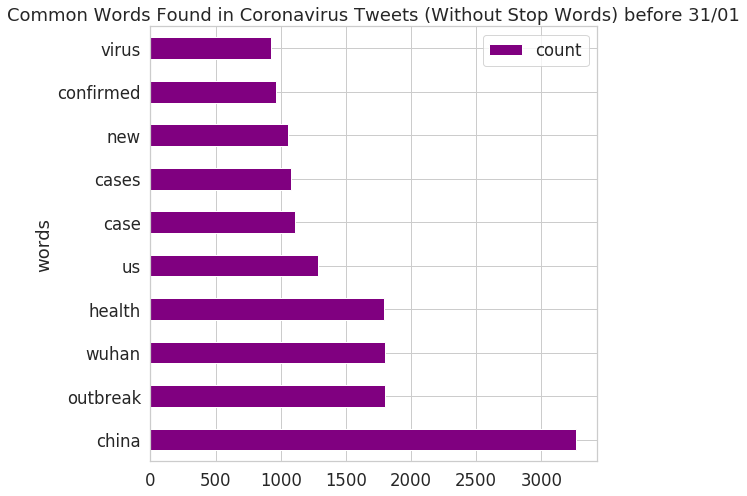

In [51]:
beforeSpike = beforeSpike.sort_values(by=['ratio'], ascending=False).head(10)
fig, ax = plt.subplots(figsize=(8, 8))

# Plot horizontal bar graph
beforeSpike.plot.barh(x='words',
                      y='count',
                      ax=ax,
                      color="purple")

ax.set_title("Common Words Found in Coronavirus Tweets (Without Stop Words) before 31/01")

plt.show()

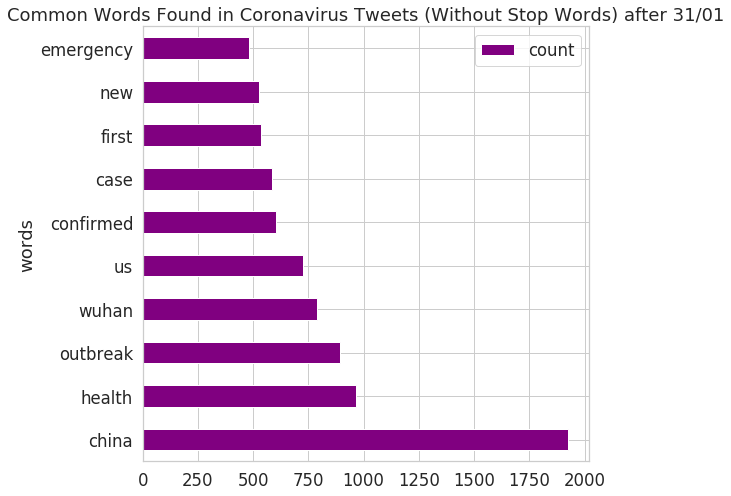

In [52]:
afterSpike = afterSpike.sort_values(by=['ratio'], ascending=False).head(10)
fig, ax = plt.subplots(figsize=(8, 8))

# Plot horizontal bar graph
afterSpike.plot.barh(x='words',
                      y='count',
                      ax=ax,
                      color="purple")

ax.set_title("Common Words Found in Coronavirus Tweets (Without Stop Words) after 31/01")

plt.show()

In [79]:
mergeDiff = beforeSpike.merge(afterSpike, left_on='words', right_on='words', how='inner')
mergeDiff['diff'] = (mergeDiff['ratio_x']-mergeDiff['ratio_y']).abs()
mergeDiff = mergeDiff.rename(columns={"ratio_x": "ratioBefore", "ratio_y": "ratioAfter"})
test = mergeDiff.sort_values(by=['diff'], ascending=False).head(10)
test.head()

,words,count_x,ratioBefore,count_y,ratioAfter,diff
2,wuhan,1801,0.043346,789,0.032831,0.010515
1,outbreak,1804,0.043419,895,0.037242,0.006177
6,new,1057,0.025440,527,0.021929,0.003511
3,health,1795,0.043202,966,0.040196,0.003006
5,case,1106,0.026619,587,0.024426,0.002193


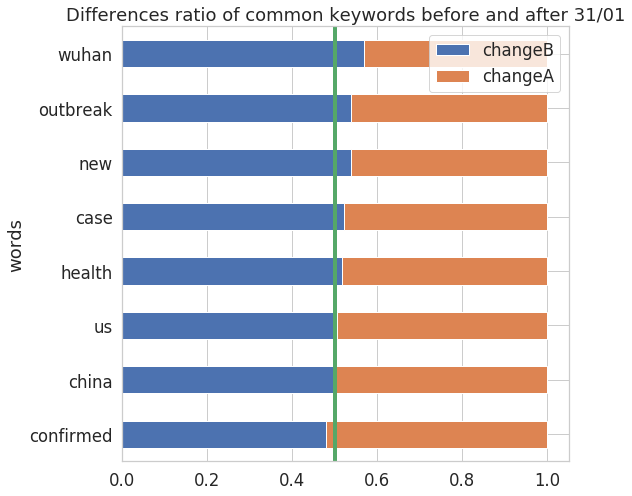

In [86]:
test['changeB'] = test['ratioBefore']/(test['ratioBefore'] + test['ratioAfter'])
test['changeA'] = test['ratioAfter']/(test['ratioBefore'] + test['ratioAfter'])
fig, ax = plt.subplots(figsize=(8, 8))

# Plot horizontal bar graph
test.sort_values(by=['changeB'], ascending=True).plot.barh(x='words',
                      y=['changeB', 'changeA'],
                      ax=ax,
                       stacked=True,
                      )

ax.set_title("Differences ratio of common keywords before and after 31/01")
plt.axvline(linewidth=4, color='g', x=0.5)

plt.show()

In [88]:
beforeSpike.count()

words    10
count    10
ratio    10
dtype: int64

## Articles titles analysis